## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


columns = ('id',
           'title',
           'category',
           'story')

train = pd.read_csv('../../data/NewsAggregatorDataset/train.feature.txt',
                    names=columns, sep='\t')
valid = pd.read_csv('../../data/NewsAggregatorDataset/valid.feature.txt',
                    names=columns, sep='\t')
test = pd.read_csv('../../data/NewsAggregatorDataset/test.feature.txt',
                   names=columns, sep='\t')

/Users/hagaakari/.pyenv/versions/3.8.0/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import re

def tokenize(doc):
    doc = re.sub(r"[',.]", '', doc)  # 記号を削除
    tokens = doc.split(' ')
    tokens = [token.lower() for token in tokens]  # 小文字に統一
    return tokens

def preprocessor(tokens):
    tokens = [token for token in tokens if token in vocab]
    return tokens

def bag_of_words(doc):
    vector = [0]*len(vocab)
    for word in doc:
        if word in vocab:
            vector[vocab.index(word)] += 1
    return pd.Series(vector)

In [3]:
# vocabulary
from collections import Counter

train['tokens'] = train.title.apply(tokenize)
vocab = train['tokens'].tolist()
vocab = sum(vocab, [])  # flat list
counter = Counter(vocab)
vocab = [
    token
    for token, freq in counter.most_common()
    if 2 < freq < 300
]

In [4]:
train['tokens'] = train.tokens.progress_apply(preprocessor)
X_train = train.tokens.progress_apply(bag_of_words)

test['tokens'] = test.title.apply(tokenize)
test['tokens'] = test.tokens.progress_apply(preprocessor)
X_test = test.tokens.progress_apply(bag_of_words)

valid['tokens'] = valid.title.apply(tokenize)
valid['tokens'] = valid.tokens.progress_apply(preprocessor)
X_valid = valid.tokens.progress_apply(bag_of_words)

100%|██████████| 1334/1334 [00:02<00:00, 478.43it/s]


## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [5]:
from sklearn.linear_model import LogisticRegression

Y_train = train['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3}) # クラスを定義
lr = LogisticRegression(class_weight='balanced') # ロジスティック回帰モデルのインスタンスを作成
lr.fit(X_train, Y_train) # ロジスティック回帰モデルの重みを学習

/Users/hagaakari/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [7]:
#  訓練データで予測
 
Y_pred = lr.predict(X_train)
Y_true = train['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3})
print('予測ラベル', Y_pred[:10])
print('正解', Y_true.head(10).tolist())

予測ラベル [3 0 2 2 0 0 0 1 2 0]
正解 [3, 0, 2, 2, 0, 0, 0, 1, 2, 0]


In [8]:
# 評価データで予測

Y_pred = lr.predict(X_test)
Y_true = test['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3})
print('予測ラベル', Y_pred[:10])
print('正解', Y_true.head(10).tolist())

予測ラベル [1 2 0 1 2 2 3 0 0 2]
正解 [1, 2, 0, 1, 2, 2, 3, 0, 0, 2]


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [9]:
def accuracy(predict, y):
    return (predict == y).mean()

In [10]:
#  訓練データの正解率

X_train = train.tokens.progress_apply(bag_of_words)
Y_pred = lr.predict(X_train)
Y_true = train['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3})

print('正解率', accuracy(Y_pred, Y_true))
# doc2vecでは 0.3256184407796102

100%|██████████| 10672/10672 [00:24<00:00, 437.82it/s]


正解率 0.9845389805097451


In [12]:
#  評価データの正解率

X_test = test.tokens.progress_apply(bag_of_words)
Y_pred = lr.predict(X_test)
Y_true = test['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3})
print('正解率', accuracy(Y_pred, Y_true))
# doc2vecでは   0.24287856071964017

100%|██████████| 1334/1334 [00:03<00:00, 403.68it/s]

正解率 0.8958020989505248


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [15]:
import numpy as np

def confusion_matrix(y_true, y_pred):
    size = len(set(y_true))
    result = np.array([0]*(size*size)).reshape((size,size)) # 配列の初期化
    for t, p in zip(y_true, y_pred):
        result[t][p] += 1
    return result

In [16]:
con_matrix = confusion_matrix(Y_true, Y_pred)
print(con_matrix)

[[498  36  10   9]
 [ 21 124   4   4]
 [ 14  14 505   5]
 [  7   8   7  68]]


## 56. 適合率，再現率，F1スコアの計測Permalink
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [17]:
def precision(con_matrix):
    size = len(con_matrix)
    results = []
    for i in range(size):
        result = con_matrix[i][i]/sum(con_matrix[i])
        results.append(result)
    return results
    
def recall(con_matrix):
    size = len(con_matrix)
    results = []
    for i in range(size):
        result = con_matrix[i][i]/sum([row[i] for row in con_matrix])
        results.append(result)
    return results

def f1(pre, rec):
    size = len(con_matrix)
    results = []
    for i in range(size):
        result = (2*rec[i]*pre[i])/(rec[i]+pre[i])
        results.append(result)
    return results

In [18]:
pre = precision(con_matrix)
rec = recall(con_matrix)
f1_score = f1(pre, rec)
print('presition', pre)
print('recall', rec)
print('f1', f1_score)
# TODO 平均の取り方はf1, recallの段階で変える？

presition [0.9005424954792043, 0.8104575163398693, 0.9386617100371747, 0.7555555555555555]
recall [0.9222222222222223, 0.6813186813186813, 0.9600760456273765, 0.7906976744186046]
f1 [0.9112534309240622, 0.7402985074626866, 0.9492481203007519, 0.7727272727272727]


In [28]:
# マクロ平均
def mean_macro(values):
    mean = 0
    for value in values:
        mean += value
    mean /= len(values)
    return mean

def mean_micro(values):
    mean = 0
    length = len(values)
    for value in values:
        mean += value/length
    return mean

print('マクロ平均   \t 適合率： %.20f, 再現率： %f, F1：%f' % (mean_macro(pre), mean_macro(rec), mean_macro(f1_score)))
print('マイクロ平均\t 適合率： %.20f, 再現率： %f, F1：%f' % (mean_macro(pre), mean_macro(rec), mean_macro(f1_score)))

マクロ平均   	 適合率： 0.85130431935295092227, 再現率： 0.838579, F1：0.843382
マイクロ平均	 適合率： 0.85130431935295092227, 再現率： 0.838579, F1：0.843382


In [ ]:
# マクロ平均
print('適合率 マクロ平均', np.array(pre).mean())
print('再現率 マクロ平均', np.array(rec).mean())
print('F1 マクロ平均', np.array(f1_score).mean())

## 57. 特徴量の重みの確認Permalink
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．



In [ ]:
lr.coef_

In [84]:
print("coefficient = ", lr.coef_) # 説明変数の係数（重み）
labels = {'b': 0, 't': 1, 'e': 2, 'm': 3}

df = pd.DataFrame()
df['word'] = vocab

for key, value in labels.items():
    df['coef'] = lr.coef_[value]
    print(key)
    print(df.sort_values('coef', ascending=False).head(10).to_string(index=False), '\n')
    print(df.sort_values('coef').head(10).to_string(index=False), '\n')

# print("intercept = ", lr.intercept_) # 切片

coefficient =  [[-0.63990247 -0.55659616 -1.08942751 ... -0.09404083 -0.06126723
  -0.081567  ]
 [-0.5264873  -0.46478526 -0.4030986  ... -0.05961833 -0.03921252
   0.15460631]
 [ 1.65678062  1.40852714  1.13529375 ...  0.19064374  0.1266009
   0.0486148 ]
 [-0.49039084 -0.38714573  0.35723237 ... -0.03698459 -0.02612115
  -0.12165411]]
b
    word   coef
    bank 1.8821
     fed 1.8606
     ecb 1.8511
 ukraine 1.7599
    euro 1.4933
 percent 1.4446
     buy 1.4222
  yellen 1.4072
     ceo 1.3854
  dollar 1.3758 

       word    coef
 activision -1.6666
      aereo -1.3548
      ebola -1.2161
       baby -1.1517
      virus -1.1466
      video -1.1096
      using -1.1072
        her -1.0894
         10 -1.0883
     people -1.0417 

t
       word   coef
   facebook 2.7562
     google 2.6558
    climate 2.5433
      apple 2.2598
 heartbleed 2.1715
  microsoft 2.1482
      tesla 2.0275
       moon 2.0117
       nasa 1.9386
        fcc 1.9197 

       word     coef
     stocks  -1.1947
    

# 58. 正則化パラメータの変更Permalink
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

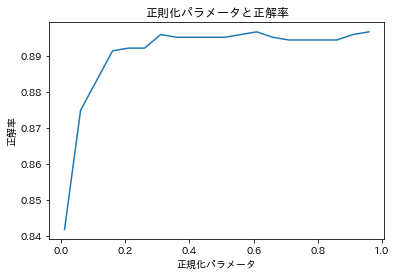

In [97]:
from matplotlib import pyplot as plt
import japanize_matplotlib
x = []
y = []
Y_train = train['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3}) # クラスを定義
Y_test = test['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3})
params = [i / 100 for i in range(1, 100, 5)]
for param in params:
    # 学習
    lr = LogisticRegression(class_weight='balanced', C=param) # ロジスティック回帰モデルのインスタンスを作成
    lr.fit(X_train, Y_train) # ロジスティック回帰モデルの重みを学習
    #  予測
    X_test = test.tokens.progress_apply(bag_of_words)
    Y_pred = lr.predict(X_test)

    x.append(param)
    y.append(accuracy(Y_pred, Y_test))

plt.plot(x, y)
plt.xlabel('正規化パラメータ')
plt.ylabel('正解率')
plt.title('正則化パラメータと正解率')
plt.show()

## 59. ハイパーパラメータの探索Permalink
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

正答率: 0.7083958020989505
正答率: 0.7736131934032984
正答率: 0.8103448275862069
正答率: 0.8320839580209896
正答率: 0.8455772113943029
正答率: 0.8620689655172413
正答率: 0.8695652173913043
正答率: 0.8740629685157422
正答率: 0.881559220389805


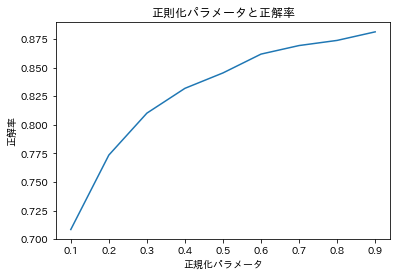

In [103]:
from sklearn.svm import SVC
x = []
y = []
Y_test = test['category'].map({'b': 0, 't': 1, 'e': 2, 'm': 3})
params = [i / 10 for i in range(1, 10, 1)]
for param in params:
    # 学習
    svm = SVC(C=param)
    svm.fit(X_train, Y_train)
    Y_pred = svm.predict(X_test)
    x.append(param)
    y.append(accuracy(Y_pred, Y_test))
    print('正答率: {}' .format(y[-1]))

plt.plot(x, y)
plt.xlabel('正規化パラメータ')
plt.ylabel('正解率')
plt.title('正則化パラメータと正解率')
plt.show()

In [100]:
# K-NearestNeighbor（K近傍法）
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

score = knn.score(X_test, Y_true)
print('正答率: {}' .format(score))

正答率: 0.5524737631184408


In [101]:
# ランダムフォレスト
from sklearn.tree import DecisionTreeClassifier
random_forest = DecisionTreeClassifier()
random_forest.fit(X_train, Y_train)

score = random_forest.score(X_test, Y_true)
print('正答率: {}' .format(score))

正答率: 0.8118440779610195
